<a href="https://colab.research.google.com/github/dawidkubicki/kaggle-dogs-vs-cats/blob/main/kaggle_dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
keras.__version__

In [3]:
# import os, shutil
# import os.path

# #path to oryginal full downloaded dataset
# original_dataset_dir = '/Users/dawidkubicki/Documents/dataset/dogs-vs-cats'

# #directory where the new files will be included
# base_dir = '/Users/dawidkubicki/Documents/dataset/cats_and_dogs_small'

# if os.path.exists('/Users/dawidkubicki/Documents/dataset/cats_and_dogs_small'):
#     print ("File exist")
# else:
#     os.mkdir(base_dir)
#     print ("File created")

File created


In [3]:
from keras.applications import VGG16

In [4]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### What are we going to do is firsty use this model conv_base with feature_extraction and later we're going to use data augmentation as well

In [6]:
import os
import numpy as np
from keras_preprocessing.image import ImageDataGenerator

base_dir = '/Users/dawidkubicki/Documents/dataset/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

### Feature extraction

In [16]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Reshape it

In [17]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### Training classificator

In [18]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid',))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 17ms/step - loss: 0.5815 - acc: 0.6855 - val_loss: 0.4385 - val_acc: 0.8300
Epoch 2/30
100/100 [==============================] - 2s 16ms/step - loss: 0.4258 - acc: 0.8235 - val_loss: 0.3738 - val_acc: 0.8420
Epoch 3/30
100/100 [==============================] - 2s 16ms/step - loss: 0.3502 - acc: 0.8525 - val_loss: 0.3438 - val_acc: 0.8510
Epoch 4/30
100/100 [==============================] - 2s 16ms/step - loss: 0.3175 - acc: 0.8715 - val_loss: 0.3194 - val_acc: 0.8660
Epoch 5/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2953 - acc: 0.8745 - val_loss: 0.3054 - val_acc: 0.8740
Epoch 6/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2649 - acc: 0.8950 - val_loss: 0.2960 - val_acc: 0.8750
Epoch 7/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2467 - acc: 0.9030 - val_loss: 0.2957 - val_acc: 0.8740
Epoch 8/30
100/100 [==============================] - 2s 16ms/step - 

### Plot results

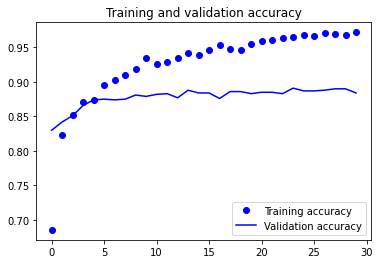

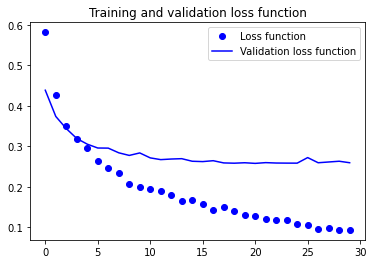

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Loss function')
plt.plot(epochs, val_loss, 'b', label='Validation loss function')
plt.title('Training and validation loss function')
plt.legend()

plt.show()

In [22]:
model.save('cats_and_dogs_small_3.h5')

In [44]:
list_key=['a','b','c','d','e']
list_value=[1,2,3,4,5]

mapowanie = {}

for klucz, wartosc in zip(list_key,list_value):
    mapowanie[klucz] = wartosc